# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.WARNING)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

import pyaldata as pyal


try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    monkey_defs = params.monkey_defs
    mouse_defs = params.mouse_defs
    
    os.chdir(RepoPath / 'monkey')
    %run "_dataset-selection.ipynb"
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
finally:
    os.chdir(nbPath)

n_components = min(monkey_defs.n_components, mouse_defs.n_components)

if "__file__" not in dir():
    reload(dt)
    reload(mouse_defs)
    reload(monkey_defs)
    print('Done!')

the variable `GoodDataList` contains the session names
Done!


# reading data

In [2]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = mouse_defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

In [3]:
warnings.filterwarnings("ignore")
allDFs_MCx = []
for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    for session in sessionList:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))
        
warnings.filterwarnings("default")

# Behavioural Correlations

Correlate behaviour during the trial  


## Correaltions to the **same** target, without time warping

trimming the trials to the same length

In [4]:
try:
    os.chdir(params.repoPath / 'monkey')
    %run "_monkey-corr.ipynb"
    
    os.chdir(params.repoPath / 'mouse')
    %run "_mouse-corr.ipynb"
finally:
    os.chdir(params.repoPath / 'common')


/home/mostafa/anaconda3/envs/cca/lib/python3.9/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


Calculate the correlations

In [5]:
if "__file__" not in dir():
    within_corrs_mice = trim_within_mouse_corr (AllDFs)
    across_corrs_mice = trim_across_mouse_corr (AllDFs)
    
    defs = params.monkey_defs
    
    within_corrs_monkeys = trim_within_monkey_corr (allDFs_MCx)
    across_corrs_monkeys = trim_across_monkey_corr (allDFs_MCx)

/tmp/ipykernel_19055/3524551333.py:4: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df = pyal.restrict_to_interval(df__, epoch_fun=defs.exec_epoch)
/tmp/ipykernel_19055/3524551333.py:27: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df2 = pyal.restrict_to_interval(df2__, epoch_fun=defs.exec_epoch)
/tmp/ipykernel_19055/3524551333.py:23: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df1 = pyal.restrict_to_interval(df1__, epoch_fun=defs.exec_epoch)


Plot distribution of Behavioural correlations

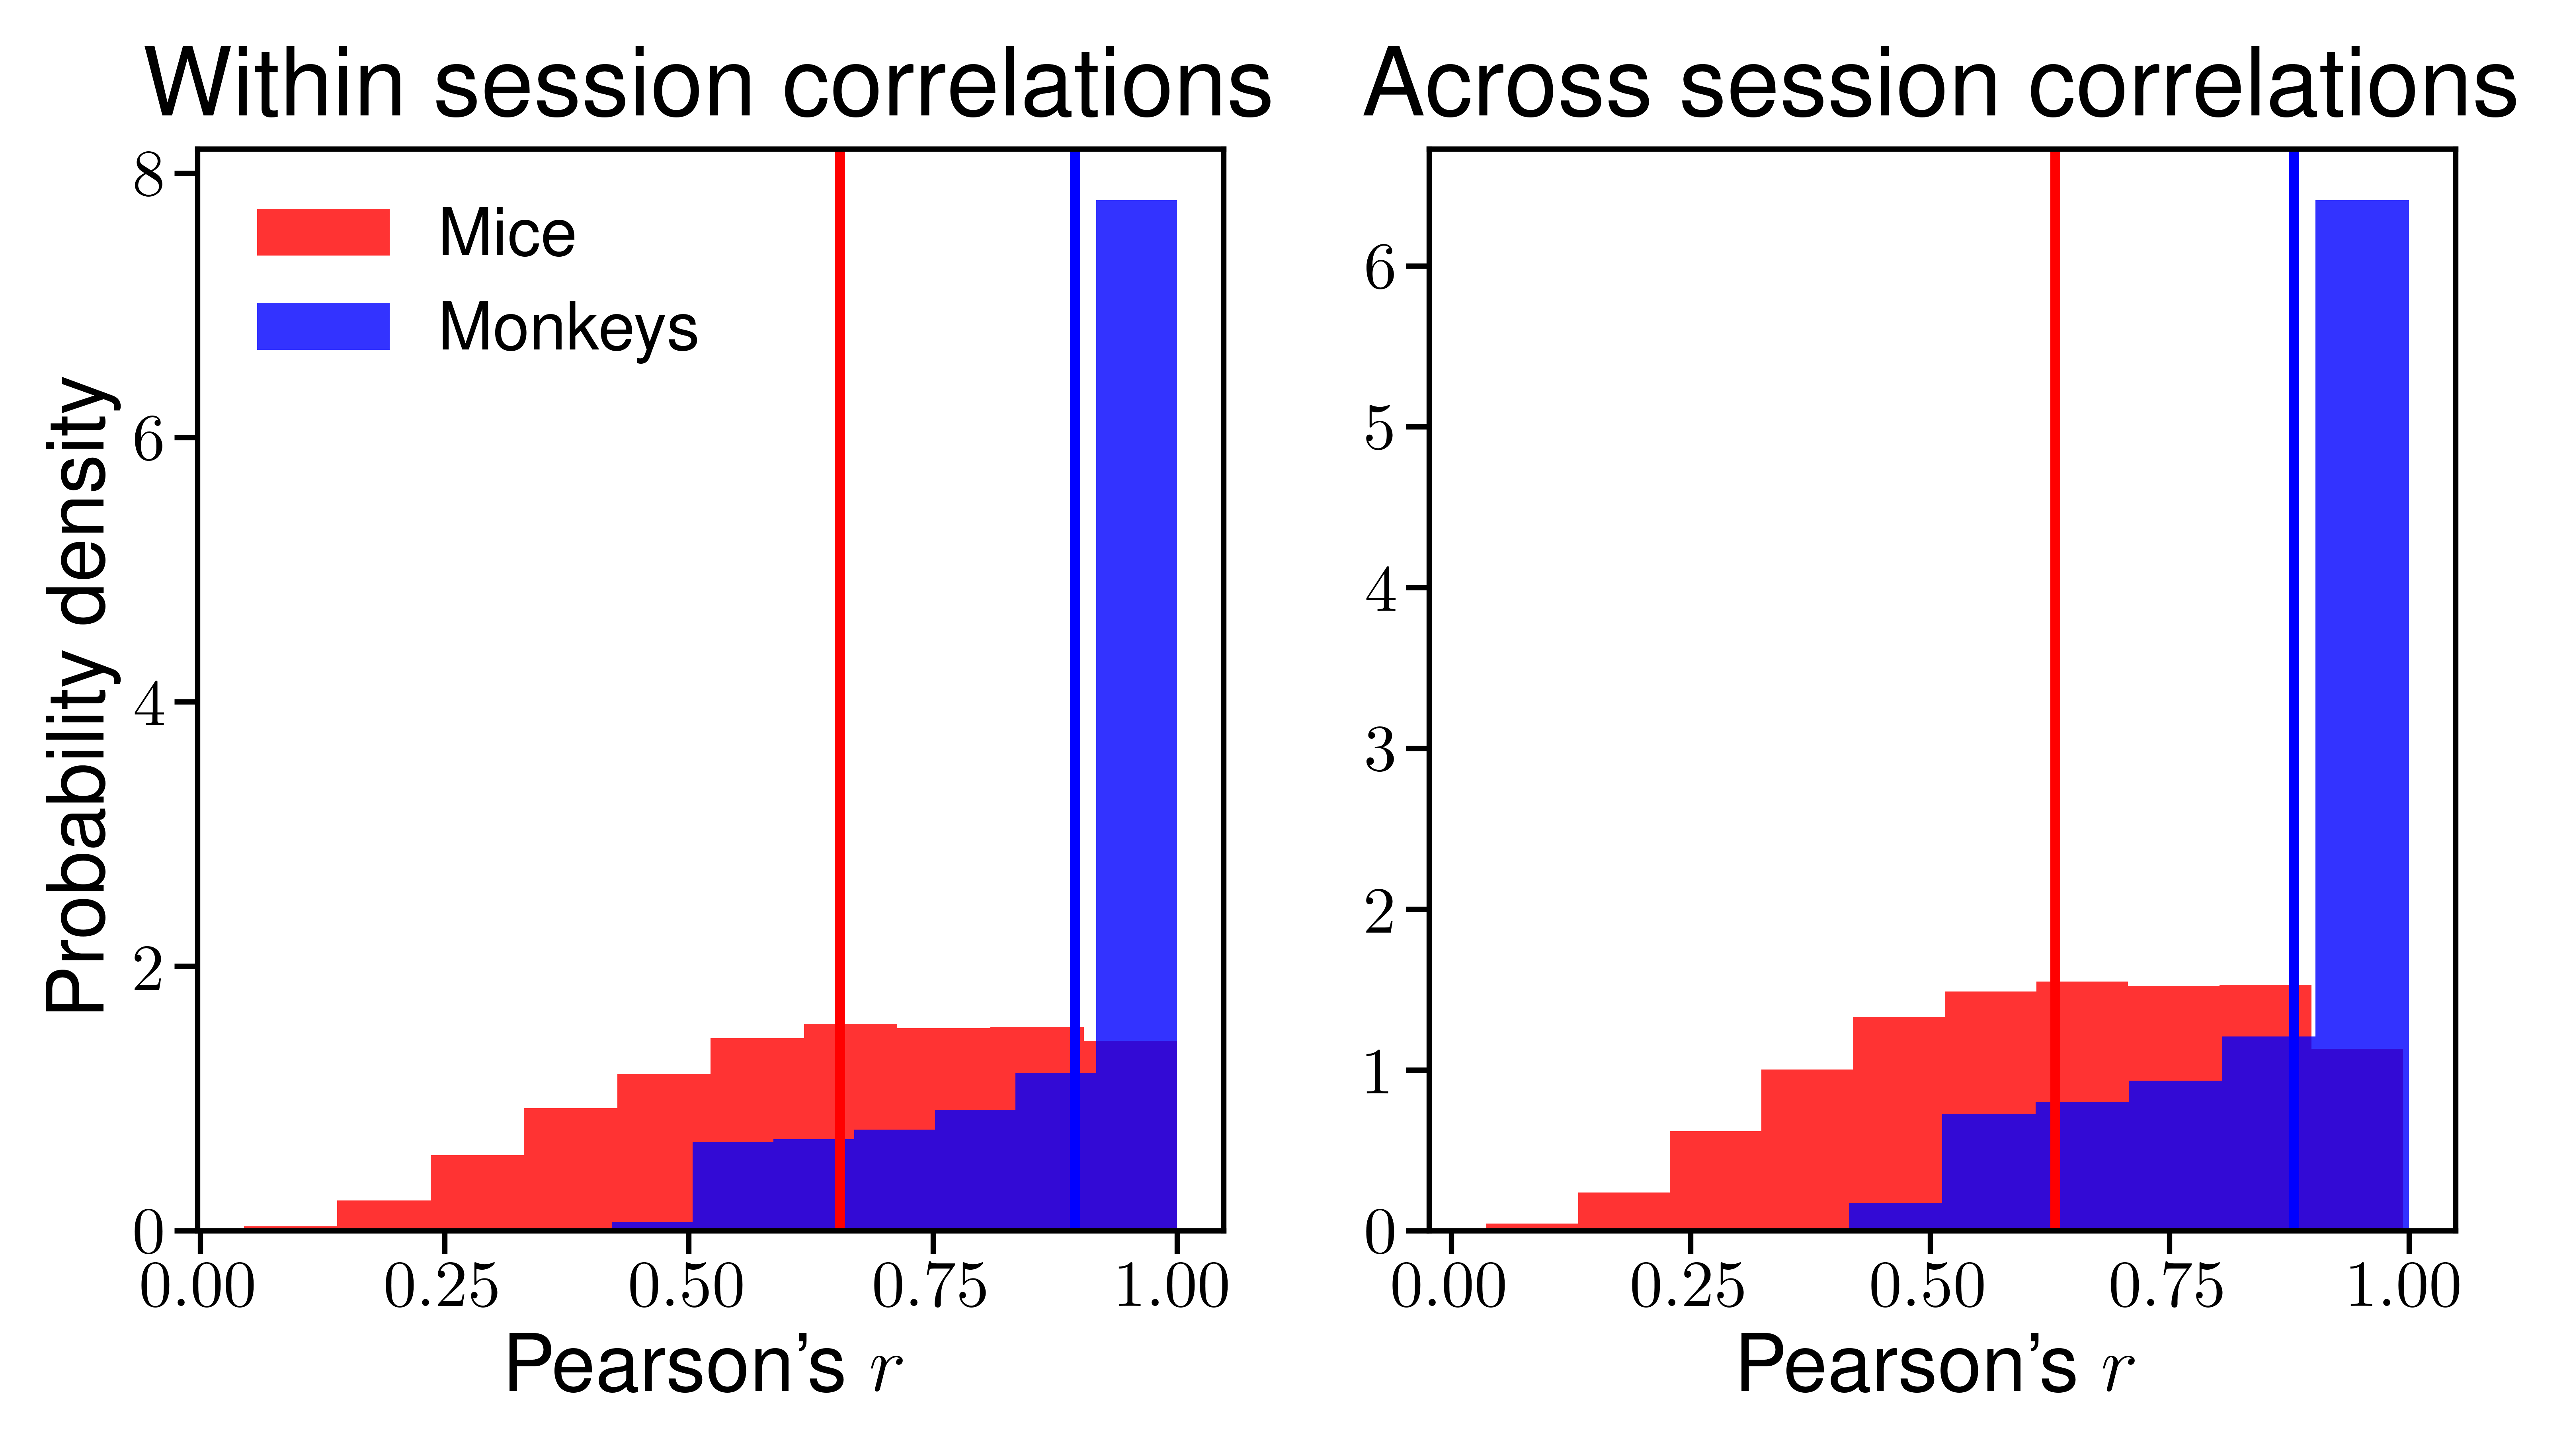

In [6]:
if "__file__" not in dir():     
    fig,axes = plt.subplots(1,2,figsize=(6.1,3))
    
    w_mice = list(within_corrs_mice.values())
    w_mice = np.array([l for L in w_mice for l in L])
    w_monkey = list(within_corrs_monkeys.values())
    w_monkey = np.array([l for L in w_monkey for l in L])
    axes[0].hist(w_mice,   density=True,alpha=.8,color='r',label=r'Mice')
    axes[0].hist(w_monkey, density=True,alpha=.8,color='b',label=r'Monkeys')
    axes[0].axvline(w_mice.mean(), color='r')
    axes[0].axvline(w_monkey.mean(), color='b')
    axes[0].set_title('Within session correlations')

    a_mice = np.array([m for L in across_corrs_mice.values() for l in L.values() for m in l])
    a_monkey = np.array([m for L in across_corrs_monkeys.values() for l in L.values() for m in l])
    axes[1].hist(a_mice, density=True, alpha=.8,color='r',label=r'Mice')
    axes[1].hist(a_monkey, density=True, alpha=.8,color='b',label=r'Monkeys')
    axes[1].axvline(a_mice.mean(), color='r')
    axes[1].axvline(a_monkey.mean(), color='b')
    axes[1].set_title('Across session correlations')
    

    axes[0].legend()
#     axes[0].set_ylabel(r"");
    
    for ax in axes:
        ax.set_xlabel(r"Pearson's $r$");
    axes[0].set_ylabel('Probability density')
    
    fig.savefig(params.figPath / 'traj-corr.pdf', format='pdf', bbox_inches='tight')

# Canonical Correlations

mice

In [8]:
pairFileList_mice = []
for I, df1 in enumerate(AllDFs):
    for J, (df2) in enumerate(AllDFs):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList_mice.append((I,J))


monkeys

In [9]:
pairFileList_monkeys = []
for I, df1 in enumerate(allDFs_MCx):
    for J, df2 in enumerate(allDFs_MCx):
        if J<=I or df1.monkey[0] == df2.monkey[0]: continue  # to repetitions
        if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue
        pairFileList_monkeys.append((I,J))

read data

In [10]:
side1df = [AllDFs[i] for i,_ in pairFileList_mice]
side2df = [AllDFs[j] for _,j in pairFileList_mice]
warnings.filterwarnings("ignore")
AllData1_mice = dt.get_data_array(side1df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=mouse_defs.n_components)
AllData2_mice = dt.get_data_array(side2df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=mouse_defs.n_components)
_,_, min_trials_mice, min_time_mice,_ = np.min((AllData1_mice.shape,AllData2_mice.shape),axis=0)

side1df = [allDFs_MCx[i] for i,_ in pairFileList_monkeys]
side2df = [allDFs_MCx[j] for _,j in pairFileList_monkeys]
AllData1_monkey = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
AllData2_monkey = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
_,_, min_trials_monkey, min_time_monkey,_ = np.min((AllData1_monkey.shape,AllData2_monkey.shape),axis=0)

warnings.filterwarnings("default")


In [11]:
CC_corr_mice=[]
for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_mice,AllData2_mice)):
    data1 = np.reshape(sessionData1[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
    k,l = pairFileList_mice[i]
    behav = np.array(across_corrs_mice[AllDFs[k].file[0]][AllDFs[l].file[0]])
    behav = behav[behav>params.Behav_corr_TH]
    CC_corr_mice.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
CC_corr_mice = np.array(CC_corr_mice)


CC_corr_monkey=[]
for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_monkey,AllData2_monkey)):
    data1 = np.reshape(sessionData1[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
    k,l = pairFileList_monkeys[i]
    behav = np.array(across_corrs_monkeys[allDFs_MCx[k].session[0]][allDFs_MCx[l].session[0]])
    behav = behav[behav>params.Behav_corr_TH]
    CC_corr_monkey.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
CC_corr_monkey = np.array(CC_corr_monkey)

plot

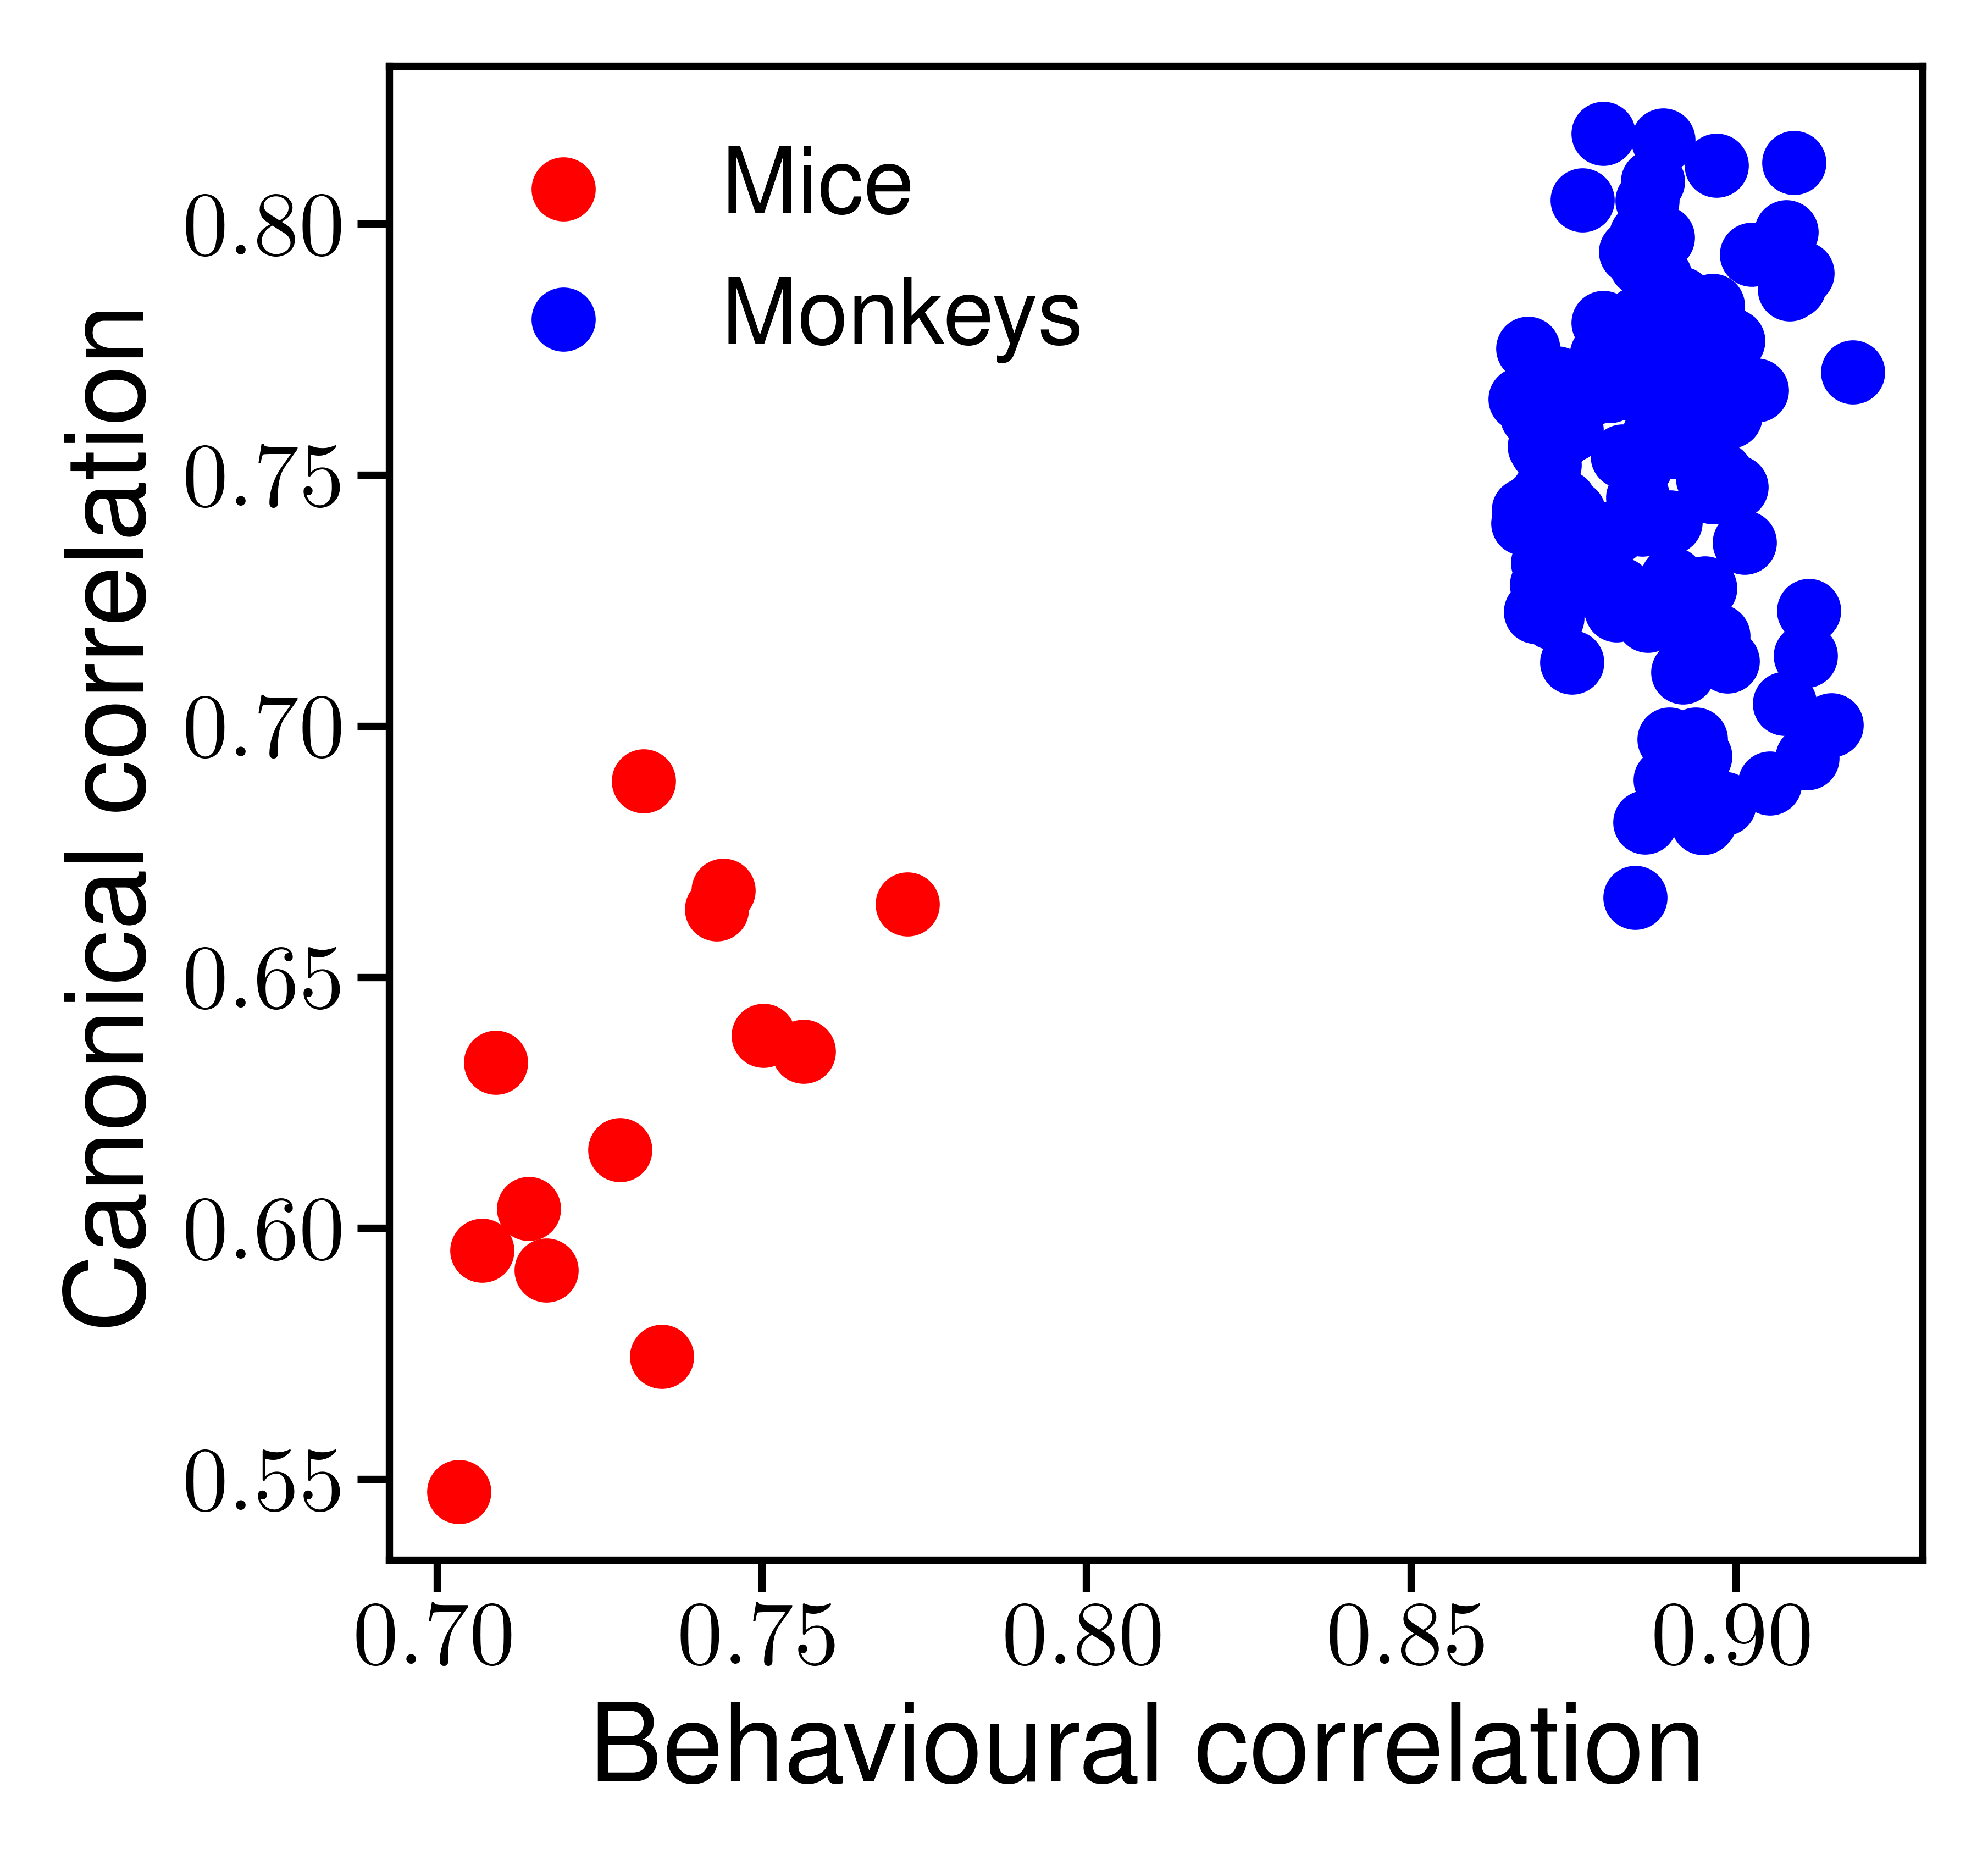

In [12]:
if "__file__" not in dir():     
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    
    ax.scatter(CC_corr_mice[:,1],CC_corr_mice[:,0],color='r', label='Mice', zorder=1)
    ax.scatter(CC_corr_monkey[:,1],CC_corr_monkey[:,0], color='b', label='Monkeys', zorder=0)

    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Canonical correlation')
    ax.legend()
    
#     ax.set_title(f'min. behav. corr.: {Behav_corr_TH:0.2f}')
    
    fig.savefig(params.figPath / 'traj-canon-corr.pdf', format='pdf', bbox_inches='tight')

---

# Add mouse$\sim$monkey data

## Behavioural correlation (target-matched)

In [13]:
def del_nan(a,b):
    L = min((len(a),len(b)))
    a = a[:L]
    b = b[:L]
    a_bad = np.isnan(a)
    b_bad = np.isnan(b)
    bad = np.logical_or(a_bad,b_bad)
    good = np.logical_not(bad)
    return a[good], b[good]

def trim_across_monkeys_and_mice(allMonkey:list[pd.DataFrame],allMouse:list[pd.DataFrame]):
    across_corrs = {}
    for dfi, df1__ in enumerate(allMonkey):
        df1 = pyal.restrict_to_interval(df1__, epoch_fun=monkey_defs.exec_epoch)
        across_corrs[df1.session[0]]={}
        for dfj, df2__ in enumerate(allMouse):
            df2 = pyal.restrict_to_interval(df2__, epoch_fun=mouse_defs.exec_epoch)
            across_corrs[df1.session[0]][df2.file[0]]=[]
            for i, pos1 in enumerate(df1.pos):
                for j, pos2 in enumerate(df2.hTrjB):
                    r = [pearsonr(*del_nan(aa,bb))[0] for aa,bb in zip(pos1.T,pos2.T)]
                    across_corrs[df1.session[0]][df2.file[0]].append(np.mean(np.abs(r)))
        
    return across_corrs

redo within species without behavioural threshold

In [14]:
CC_corr_mice_noTH=[]
for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_mice,AllData2_mice)):
    data1 = np.reshape(sessionData1[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
    k,l = pairFileList_mice[i]
    behav = np.array(across_corrs_mice[AllDFs[k].file[0]][AllDFs[l].file[0]])
    # behav = behav[behav>params.Behav_corr_TH]
    CC_corr_mice_noTH.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
CC_corr_mice_noTH = np.array(CC_corr_mice_noTH)


CC_corr_monkey_noTH=[]
for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_monkey,AllData2_monkey)):
    data1 = np.reshape(sessionData1[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
    k,l = pairFileList_monkeys[i]
    behav = np.array(across_corrs_monkeys[allDFs_MCx[k].session[0]][allDFs_MCx[l].session[0]])
    # behav = behav[behav>params.Behav_corr_TH]
    CC_corr_monkey_noTH.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
CC_corr_monkey_noTH = np.array(CC_corr_monkey_noTH)

In [15]:
allMonkey = allDFs_MCx
allMouse = AllDFs

across_animal_corrs = trim_across_monkeys_and_mice(allMonkey=allDFs_MCx, allMouse=AllDFs)


pairDfM1 = []
for I, monkey_df in enumerate(allMonkey):
    for J, mouse_df in enumerate(allMouse):
        pairDfM1.append((monkey_df,mouse_df))

side1df = [monkey for monkey,_ in pairDfM1]
side2df = [mouse for _,mouse in pairDfM1]

warnings.filterwarnings("ignore")
AllData_monkey = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=n_components)
AllData_mouse = dt.get_data_array(side2df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=n_components)
warnings.filterwarnings("default")

CC_corr_across=[]
for i, (sessionData1,sessionData2) in enumerate(zip(AllData_monkey,AllData_mouse)):
    # concatenate the targets along the trials
    data1 = np.reshape(sessionData1, (-1,*sessionData1.shape[2:]))
    data2 = np.reshape(sessionData2, (-1,*sessionData2.shape[2:]))
    min_trials, min_time,_ = np.min((data2.shape,data1.shape),axis=0)

    r = []
    for _ in range(params.n_iter * 10):
        # shuffle the trial x target axis
        params.rng.shuffle(data1,axis=0)
        params.rng.shuffle(data2,axis=0)
        data1_ = np.reshape(data1[:min_trials,:min_time,:], (-1,n_components))
        data2_ = np.reshape(data2[:min_trials,:min_time,:], (-1,n_components))
        r.append(dt.canoncorr(data1_, data2_))
    CCs = np.mean(np.array(r), axis=0)
    behav = np.array(across_animal_corrs[side1df[i].session[0]][side2df[i].file[0]])
    # behav = behav[behav>params.Behav_corr_TH]
    CC_corr_across.append((CCs[:4].mean(), behav.mean()))
CC_corr_across = np.array(CC_corr_across)


/tmp/ipykernel_19055/4179135883.py:14: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df1 = pyal.restrict_to_interval(df1__, epoch_fun=monkey_defs.exec_epoch)


plot

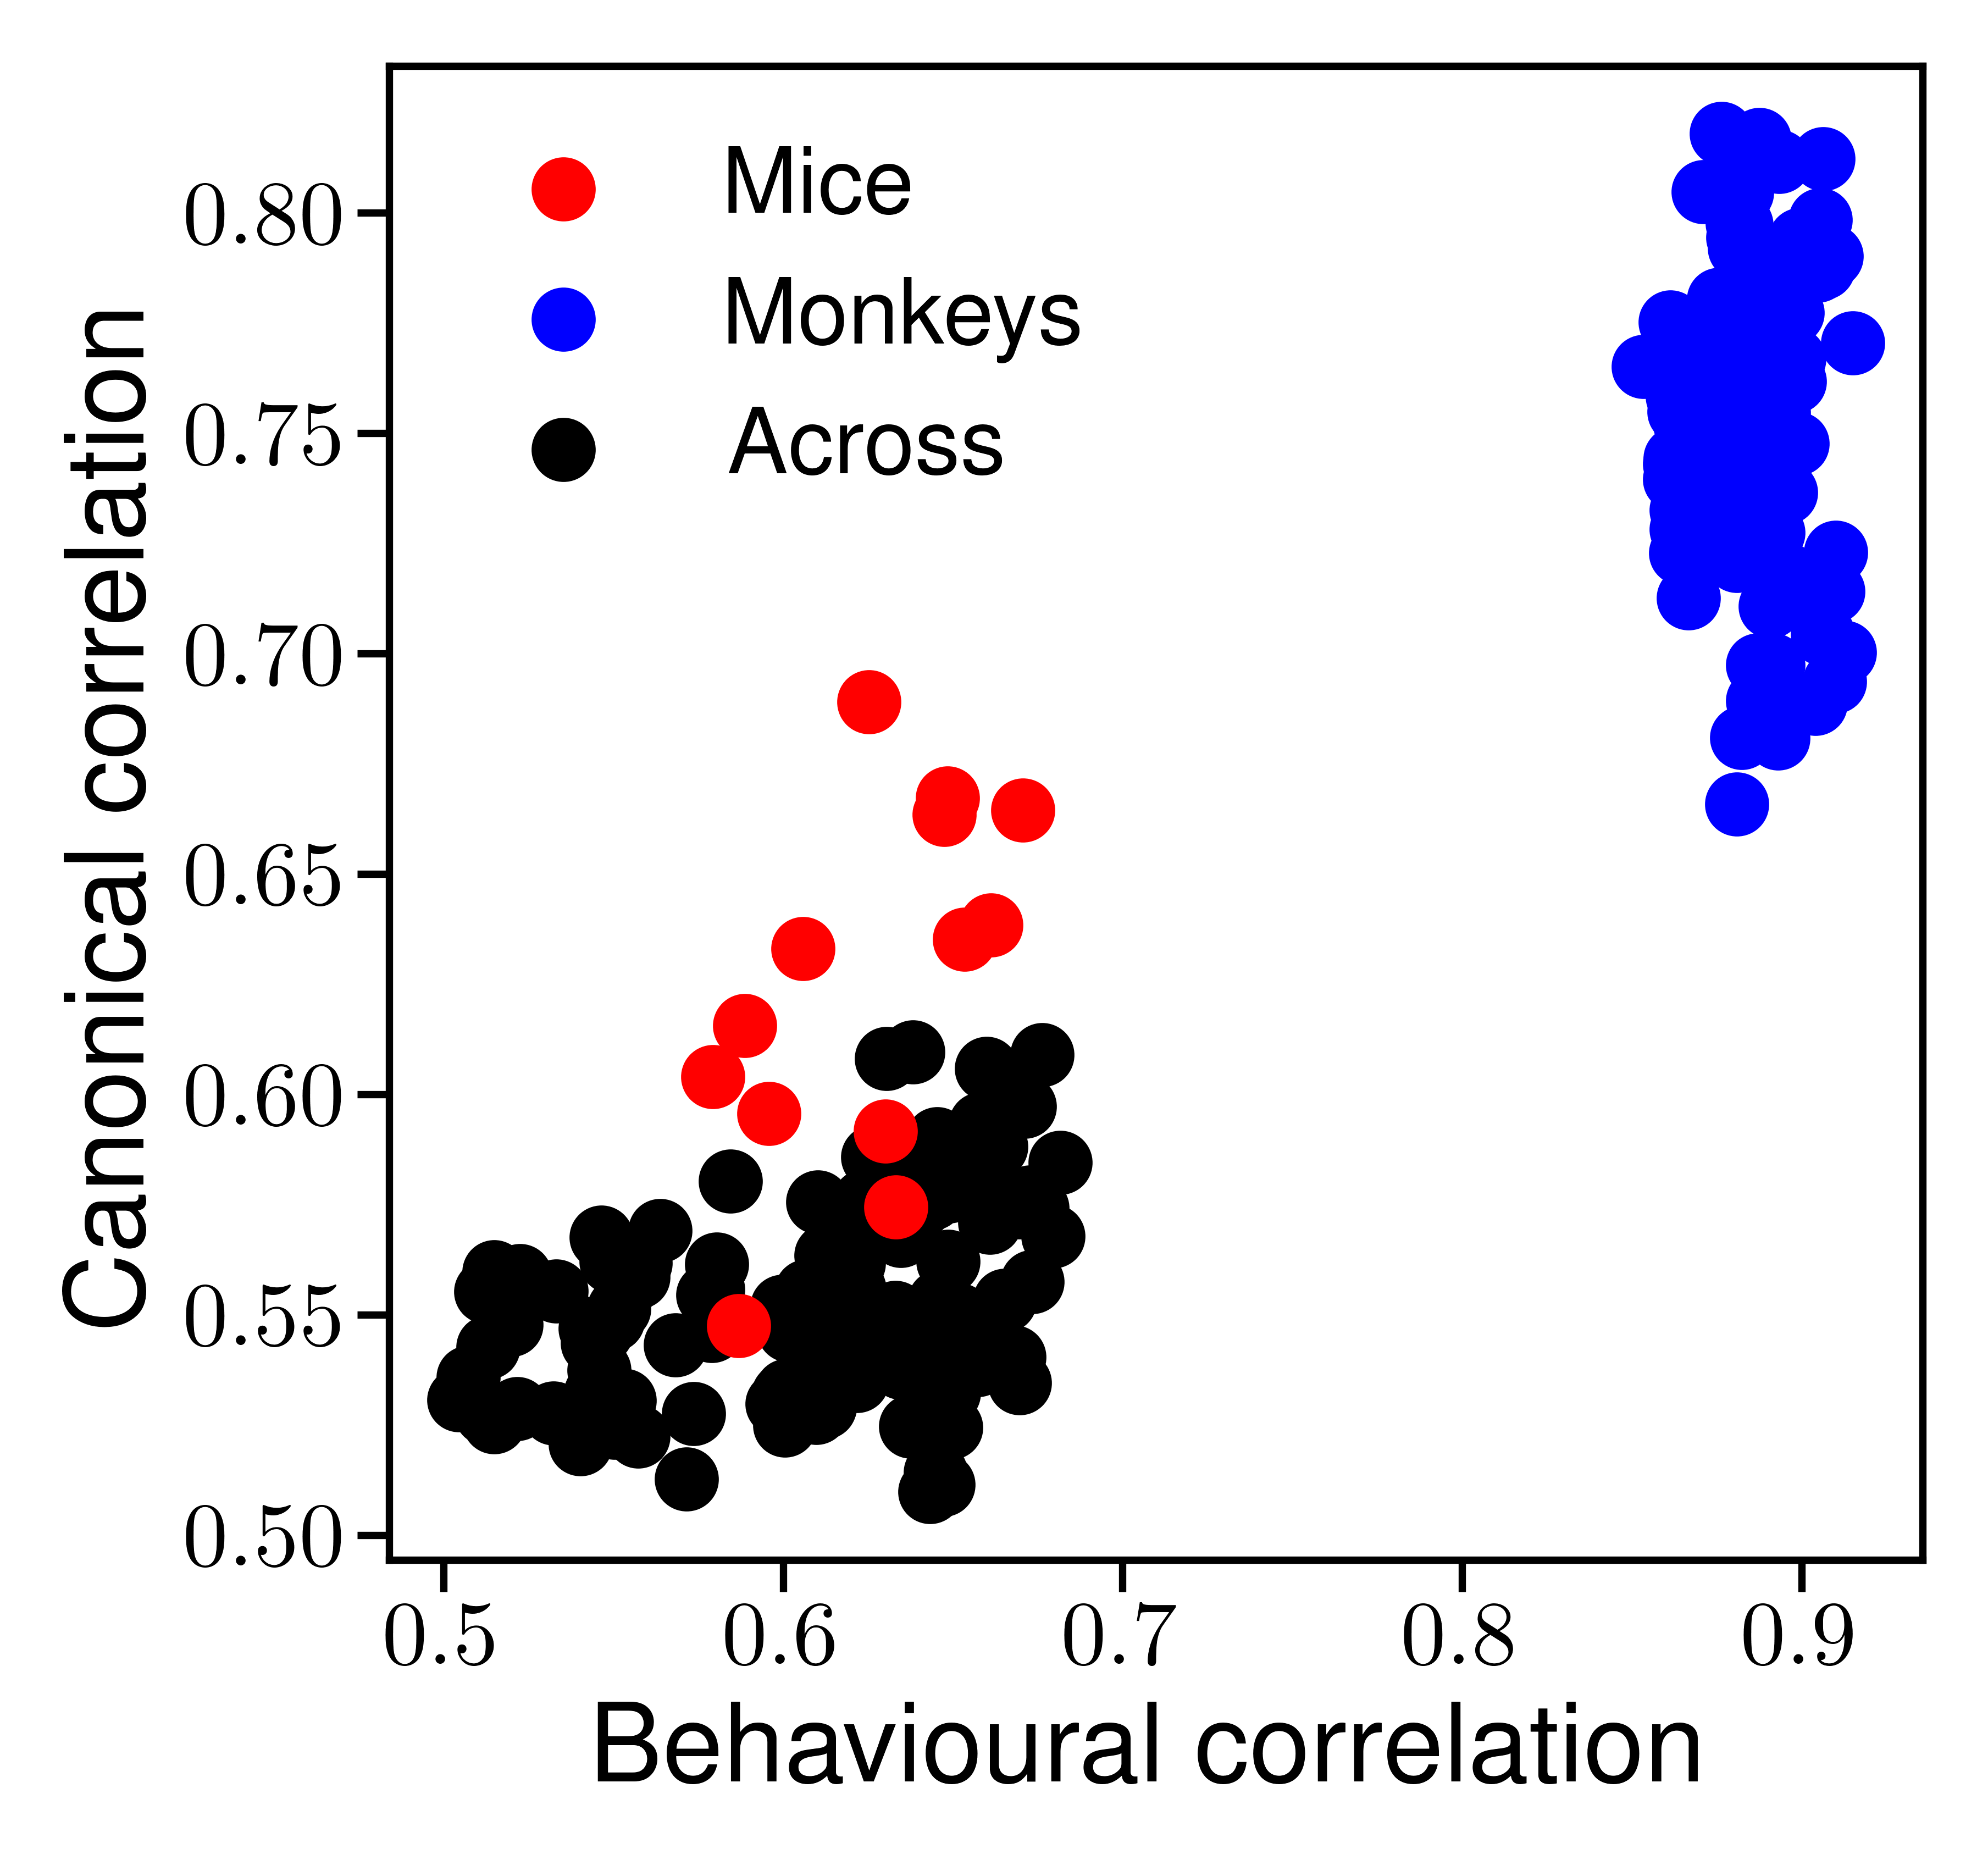

In [16]:
if "__file__" not in dir():     
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    
    ax.scatter(CC_corr_mice_noTH[:,1],CC_corr_mice_noTH[:,0],color='r', label='Mice', zorder=1)
    ax.scatter(CC_corr_monkey_noTH[:,1],CC_corr_monkey_noTH[:,0], color='b', label='Monkeys', zorder=0)
    ax.scatter(CC_corr_across[:,1],CC_corr_across[:,0], color='k', label='Across', zorder=0)

    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Canonical correlation')
    
    # ax.set_xlim([0,1])
    # ax.set_ylim([0,1])
    ax.legend()
    
    
#     ax.set_title(f'min. behav. corr.: {Behav_corr_TH:0.2f}')
    
    fig.savefig(params.figPath / 'traj-canon-corr-noTH.pdf', format='pdf', bbox_inches='tight')

# Mice and monkey only to a _single_ target

this will make them more similar in terms oftask dimentionality, hence the **Across** will be more comparable to the within species:
- Mice: include `target_id == 0 | 3`, ie the right target, both weights (to increease the number of trials)
- Monkeys: only the target in front of the animal, ie `target_id == 5`

---

read data

In [34]:
allMiceSingleDF =[]
for df in AllDFs:
    df1 = pyal.select_trials(df, df.target_id == 0)
    df2 = pyal.select_trials(df, df.target_id == 3)
    df2['target_id'] = 0
    allMiceSingleDF.append(pyal.concat_TDs((df1,df2)))

allMonkeySingleDF =[]
for df in allDFs_MCx:
    df1 = pyal.select_trials(df, df.target_id == 5)
    allMonkeySingleDF.append(df1)

do within species CCA

In [28]:
side1df = [allMiceSingleDF[i] for i,_ in pairFileList_mice]
side2df = [allMiceSingleDF[j] for _,j in pairFileList_mice]
warnings.filterwarnings("ignore")
AllData1_mice_single = dt.get_data_array(side1df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=mouse_defs.n_components)
AllData2_mice_single = dt.get_data_array(side2df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=mouse_defs.n_components)
_,_, min_trials_mice, min_time_mice,_ = np.min((AllData1_mice.shape,AllData2_mice.shape),axis=0)

side1df = [allMonkeySingleDF[i] for i,_ in pairFileList_monkeys]
side2df = [allMonkeySingleDF[j] for _,j in pairFileList_monkeys]
AllData1_monkey_single = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
AllData2_monkey_single = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
_,_, min_trials_monkey, min_time_monkey,_ = np.min((AllData1_monkey.shape,AllData2_monkey.shape),axis=0)

warnings.filterwarnings("default")


do behavoural correlation

In [30]:
defs = params.mouse_defs
across_corrs_mice_single_target = trim_across_mouse_corr (allMiceSingleDF)

defs = params.monkey_defs

across_corrs_monkeys_single_target = trim_across_monkey_corr (allMonkeySingleDF)
del defs

across_animal_single_target = trim_across_monkeys_and_mice(allMonkey=allMonkeySingleDF, allMouse=allMiceSingleDF)

reformat the across species data

In [31]:
pairDfM1 = []
for I, monkey_df in enumerate(allMonkeySingleDF):
    for J, mouse_df in enumerate(allMiceSingleDF):
        pairDfM1.append((monkey_df,mouse_df))

side1df = [monkey for monkey,_ in pairDfM1]
side2df = [mouse for _,mouse in pairDfM1]

warnings.filterwarnings("ignore")
AllData_monkey_single = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=n_components)
AllData_mouse_single = dt.get_data_array(side2df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=n_components)
warnings.filterwarnings("default")

CC_corr_across_single_target=[]
for i, (sessionData1,sessionData2) in enumerate(zip(AllData_monkey_single,AllData_mouse_single)):
    # concatenate the targets along the trials
    data1 = np.reshape(sessionData1, (-1,*sessionData1.shape[2:]))
    data2 = np.reshape(sessionData2, (-1,*sessionData2.shape[2:]))
    min_trials, min_time,_ = np.min((data2.shape,data1.shape),axis=0)

    r = []
    for _ in range(params.n_iter * 10):
        # shuffle the trial x target axis
        params.rng.shuffle(data1,axis=0)
        params.rng.shuffle(data2,axis=0)
        data1_ = np.reshape(data1[:min_trials,:min_time,:], (-1,n_components))
        data2_ = np.reshape(data2[:min_trials,:min_time,:], (-1,n_components))
        r.append(dt.canoncorr(data1_, data2_))
    CCs = np.mean(np.array(r), axis=0)
    behav = np.array(across_animal_single_target[side1df[i].session[0]][side2df[i].file[0]])
    # behav = behav[behav>params.Behav_corr_TH]
    CC_corr_across_single_target.append((CCs[:4].mean(), behav.mean()))
CC_corr_across_single_target = np.array(CC_corr_across_single_target)


reformat the within species data

In [32]:
CC_corr_mice_single_target=[]
for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_mice_single,AllData2_mice_single)):
    data1 = np.reshape(sessionData1[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
    k,l = pairFileList_mice[i]
    behav = np.array(across_corrs_mice_single_target[allMiceSingleDF[k].file[0]][allMiceSingleDF[l].file[0]])
    # behav = behav[behav>params.Behav_corr_TH]
    CC_corr_mice_single_target.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
CC_corr_mice_single_target = np.array(CC_corr_mice_single_target)


CC_corr_monkey_single_target=[]
for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_monkey_single,AllData2_monkey_single)):
    data1 = np.reshape(sessionData1[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
    k,l = pairFileList_monkeys[i]
    behav = np.array(across_corrs_monkeys_single_target[allMonkeySingleDF[k].session[0]][allMonkeySingleDF[l].session[0]])
    # behav = behav[behav>params.Behav_corr_TH]
    CC_corr_monkey_single_target.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
CC_corr_monkey_single_target = np.array(CC_corr_monkey_single_target)

plot

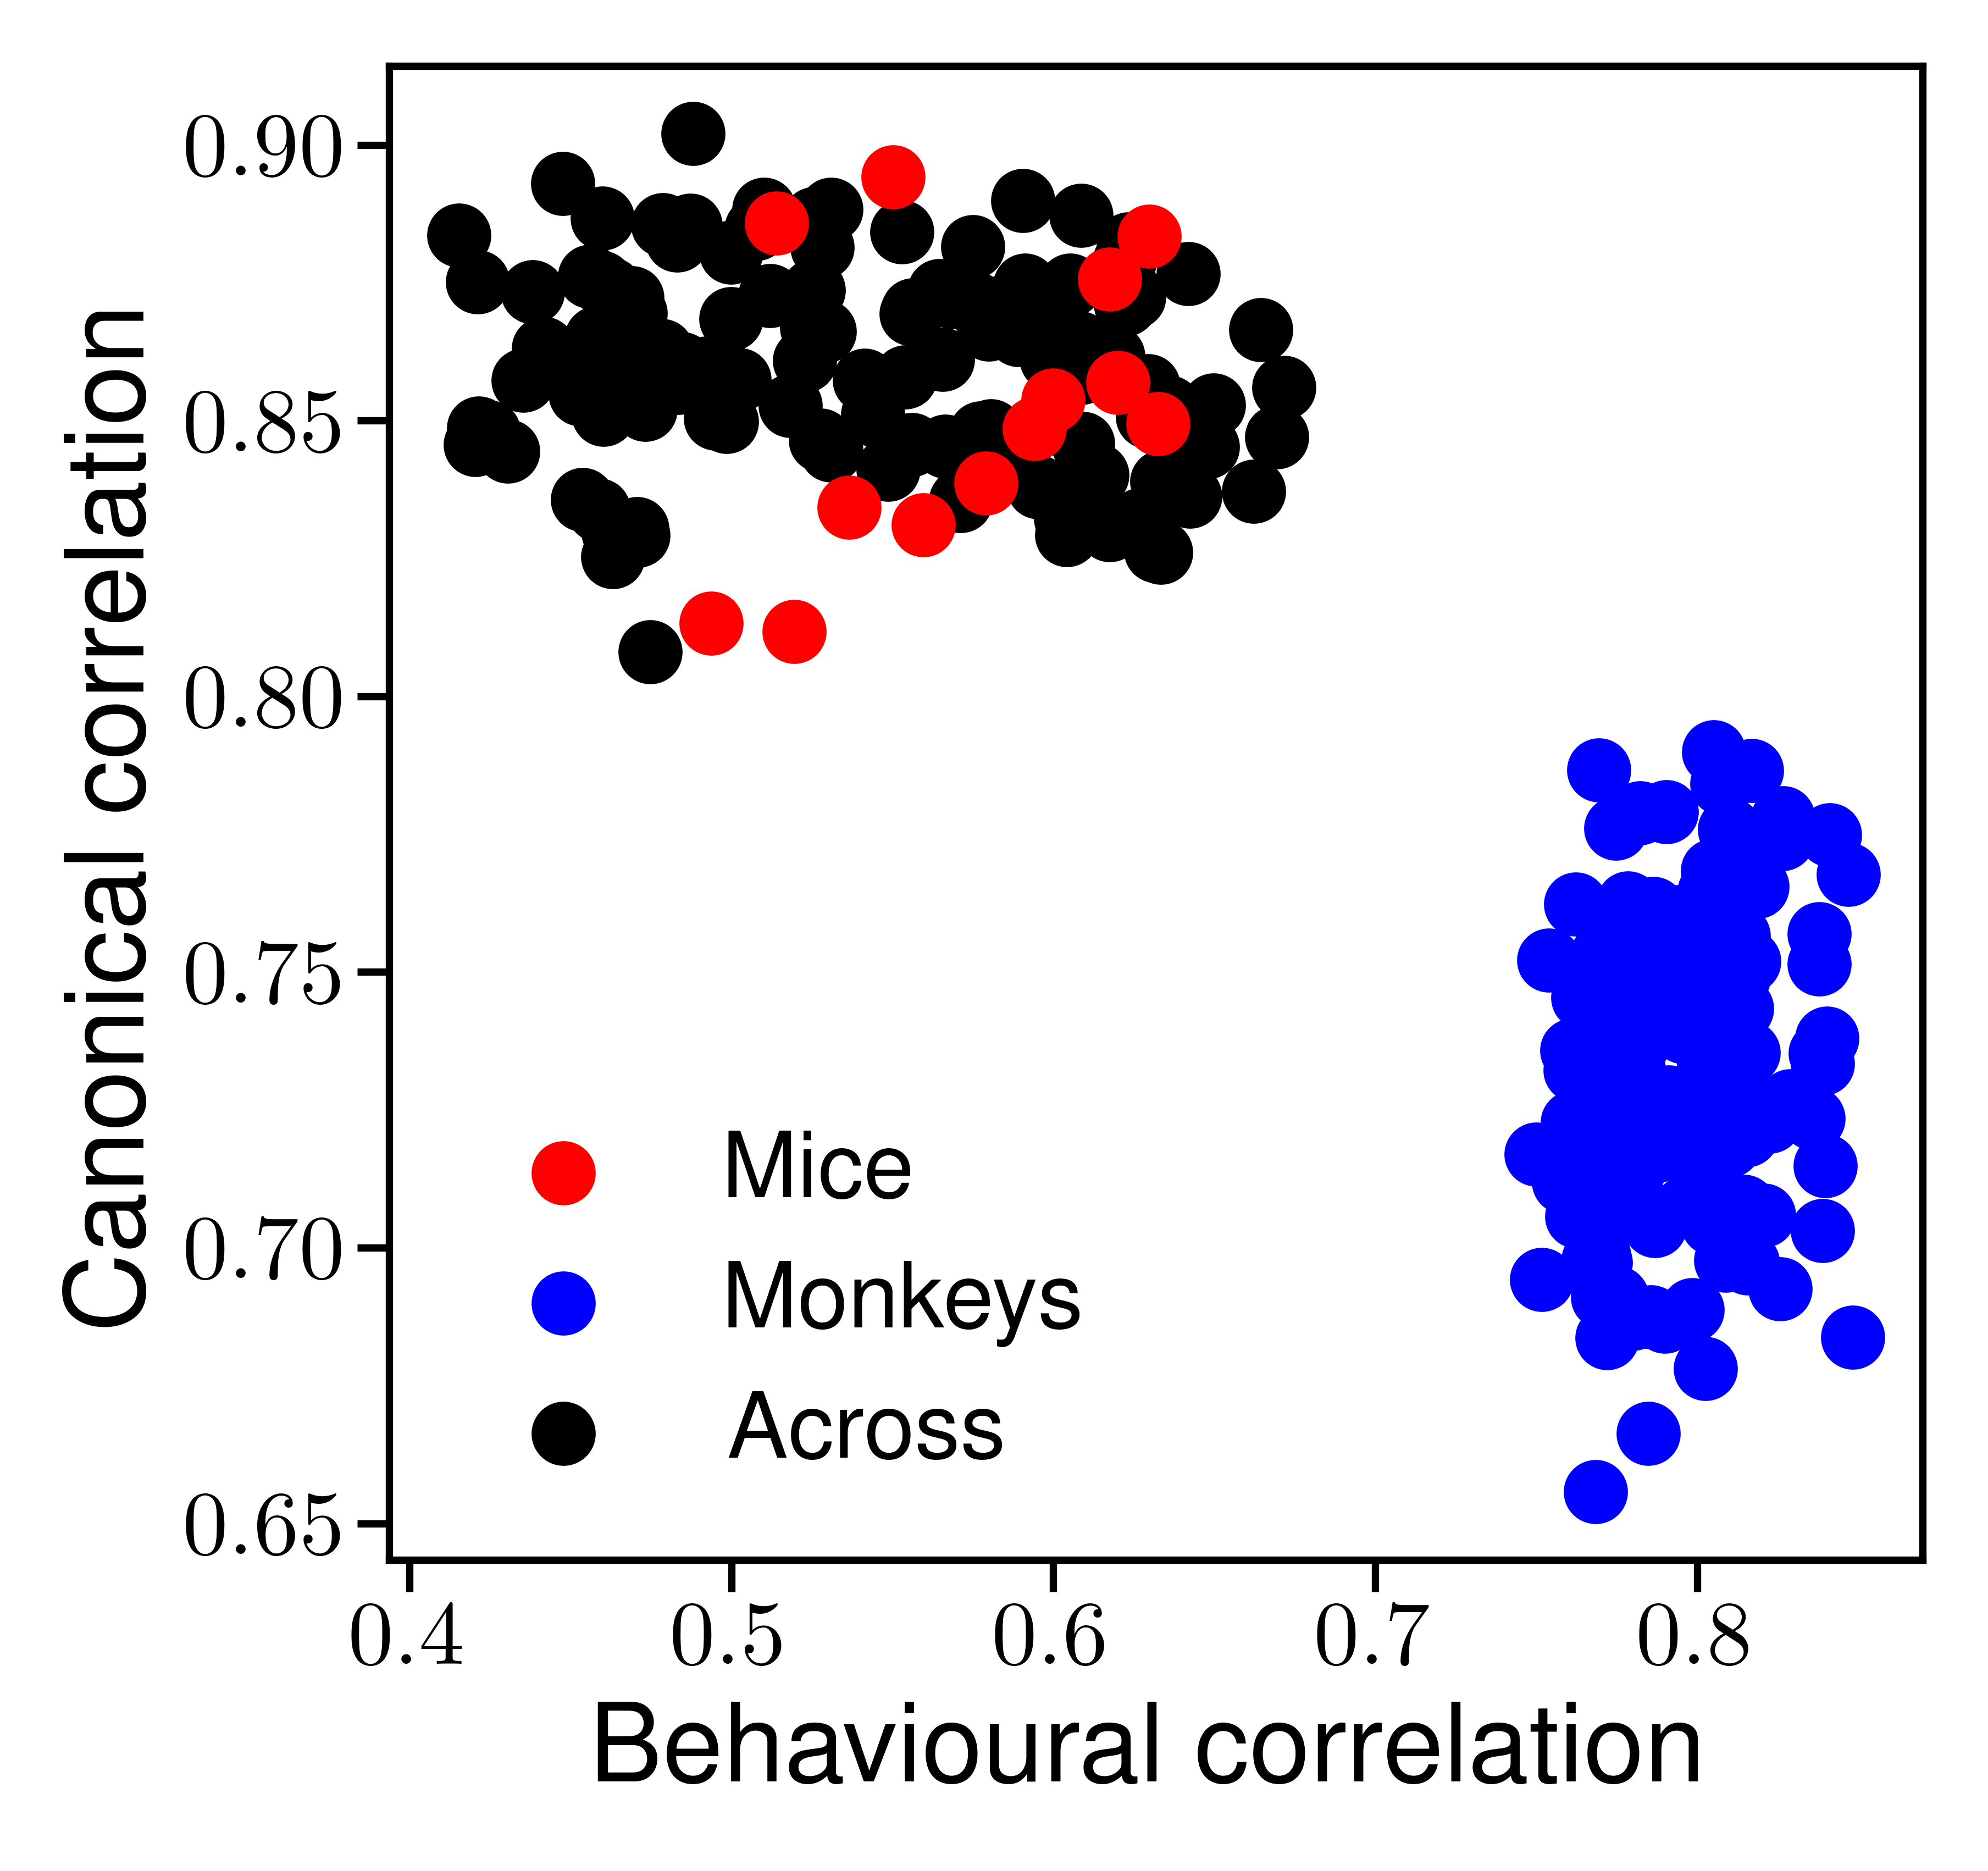

In [33]:
if "__file__" not in dir():     
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    
    ax.scatter(CC_corr_mice_single_target[:,1],CC_corr_mice_single_target[:,0],color='r', label='Mice', zorder=1)
    ax.scatter(CC_corr_monkey_single_target[:,1],CC_corr_monkey_single_target[:,0], color='b', label='Monkeys', zorder=0)
    ax.scatter(CC_corr_across_single_target[:,1],CC_corr_across_single_target[:,0], color='k', label='Across', zorder=0)

    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Canonical correlation')
    
    # ax.set_xlim([0,1])
    # ax.set_ylim([0,1])
    ax.legend()
    
    
#     ax.set_title(f'min. behav. corr.: {Behav_corr_TH:0.2f}')
    
    # fig.savefig(params.figPath / 'traj-canon-corr-noTH-single-target.pdf', format='pdf', bbox_inches='tight')